In [1]:
import timeit
import datetime as dt
import os
import subprocess 

import pandas as pd
import numpy as np



#visualization
import matplotlib.pyplot as plt
#import plotly.graph_objs as go
%matplotlib inline
#visualization with seaborn
import seaborn as sns
#visualization with plotly 
import plotly.graph_objects as go #for candle chart visualization
import plotly.express as px #for html output


#to get financial data
from pandas_datareader import data as pdr


#for webscraping 
import requests
from bs4 import BeautifulSoup 
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import pandas as pd
import requests


#for pdf report generation
from reportlab.pdfgen import canvas
from reportlab.platypus import *
from reportlab.lib import colors
from reportlab.lib.pagesizes import letter, landscape
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch
from reportlab.platypus.tableofcontents import TableOfContents


/Users/reejungkim/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
days_to_lookback = int (input('days to search financial data:'))

days to search financial data:10


In [3]:
date_end = dt.datetime.now() #.today()
date_start = date_end - dt.timedelta(days_to_lookback)

# Create timestamped folder to save reports created later

In [4]:
#timestamp = str(dt.datetime.now()) <- '2020-06-26 20:26:08.775766'  
timestamp =  dt.datetime.now().strftime('%Y-%m-%d %H-%M-%S')
timestamp

'2020-07-03 23-31-21'

In [5]:
path = os.getcwd() 
reportDir = os.path.join(path, "Output" + timestamp)
reportDir

'/Users/reejungkim/Documents/Git/reporting automation/Output2020-07-03 23-31-21'

In [6]:
#create named folder
os.makedirs(reportDir, exist_ok = False)

In [7]:
os.chdir(reportDir)

# Web scraping S&P100 companies from Wikipedia table

In [8]:
website_url = requests.get("https://en.wikipedia.org/wiki/S%26P_100").text

soup = BeautifulSoup(website_url,'lxml')
#print(soup.prettify())

In [9]:
wiki_table = soup.find('table',{'class':'wikitable sortable'})

In [10]:
data = []
tHeader = []
SP100_tickers = pd.DataFrame()

for tr in wiki_table.find_all("tr"):
    for th in tr.find_all("th")[:1]:
        tHeader = th.get_text(strip=True)
        SP100_tickers[tHeader] = []
    for td in tr.find_all("td")[:1]:
        data.append( td.get_text(strip=True))
        
SP100_tickers[tHeader] = data

In [11]:
SP100_tickers

,Symbol
0,AAPL
1,ABBV
2,ABT
3,ACN
4,ADBE
...,...
96,VZ
97,WBA
98,WFC
99,WMT


# Use DataReader to get financial data of S&P100 companies from yahoo

In [12]:
%%time

df = pd.DataFrame()

for i in data:
    symbol = SP100_tickers.loc[SP100_tickers['Symbol']==i]
    try:
        symbol_data = pdr.DataReader(i, 'yahoo', date_start, date_end).reset_index() 
    except (KeyError, ValueError):  # the error could possibly occur when there's "." in stock name 
        symbol_data = pdr.DataReader(i.replace('.','-'), 'yahoo', date_start, date_end).reset_index()
        pass
    except:
        print(i + " - Error.")
        symbol_data = pd.DataFrame()
        pass
    single_table = pd.concat([symbol, symbol_data], axis=0, ignore_index=True) #axis=0 <- row. add frames by row and use fill down.
    single_table['Symbol'].ffill(inplace=True)
    df = df.append(single_table)
    

CPU times: user 6.87 s, sys: 606 ms, total: 7.47 s
Wall time: 56.2 s


In [13]:
df = df.loc[df['Date'].notnull()]

In [14]:
df = df.reset_index(drop=True)

df.groupby(['Symbol']).describe().transpose()

In [15]:
df_Flat = df

# Analytics

###  main data frames to be used: 
#### 1. df_Flat
#### 2. df  
#### 3. df_Flat_pct_change

In [16]:
df_Flat

,Symbol,Date,High,Low,Open,Close,Volume,Adj Close
0,AAPL,2020-06-24,368.790009,358.519989,365.000000,360.059998,48155800.0,360.059998
1,AAPL,2020-06-25,365.000000,357.570007,360.700012,364.839996,34380600.0,364.839996
2,AAPL,2020-06-26,365.320007,353.019989,364.410004,353.630005,51314200.0,353.630005
3,AAPL,2020-06-29,362.170013,351.279999,353.250000,361.779999,32661500.0,361.779999
4,AAPL,2020-06-30,365.980011,360.000000,360.079987,364.799988,35055800.0,364.799988
...,...,...,...,...,...,...,...,...
702,XOM,2020-06-26,44.939999,43.500000,44.880001,43.619999,31518600.0,43.619999
703,XOM,2020-06-29,44.580002,43.540001,43.810001,44.320000,17052100.0,44.320000
704,XOM,2020-06-30,44.970001,43.160000,43.430000,44.720001,22153600.0,44.720001
705,XOM,2020-07-01,45.380001,43.669998,44.490002,43.709999,17290100.0,43.709999


In [17]:
df = df.groupby(['Symbol', 'Date']).sum()
df

High         Low        Open       Close      Volume  \
Symbol Date                                                                     
AAPL   2020-06-24  368.790009  358.519989  365.000000  360.059998  48155800.0   
       2020-06-25  365.000000  357.570007  360.700012  364.839996  34380600.0   
       2020-06-26  365.320007  353.019989  364.410004  353.630005  51314200.0   
       2020-06-29  362.170013  351.279999  353.250000  361.779999  32661500.0   
       2020-06-30  365.980011  360.000000  360.079987  364.799988  35055800.0   
...                       ...         ...         ...         ...         ...   
XOM    2020-06-26   44.939999   43.500000   44.880001   43.619999  31518600.0   
       2020-06-29   44.580002   43.540001   43.810001   44.320000  17052100.0   
       2020-06-30   44.970001   43.160000   43.430000   44.720001  22153600.0   
       2020-07-01   45.380001   43.669998   44.490002   43.709999  17290100.0   
       2020-07-02   45.189999   43.930000   44.619999   44.080002  18195800.0   

                    Adj Close  
Symbol Date                    
AAPL   2020-06-24  360.059998  
       2020-06-25  364.839996  
       2020-06-26  353.630005  
       2020-06-29  361.779999  
       2020-06-30  364.799988  
...                       ...  
XOM    2020-06-26   43.619999  
       2020-06-29   44.320000  
       2020-06-30   44.720001  
       2020-07-01   43.709999  
       2020-07-02   44.080002  

[707 rows x 6 columns]

In [186]:
df_Flat_pct_change = df_Flat.pivot_table( index='Date', columns='Symbol', aggfunc=np.sum, margins=False)
df_Flat_pct_change = df_Flat_pct_change/df_Flat_pct_change.shift(1)
df_Flat_pct_change = df_Flat_pct_change.stack(1)
df_Flat_pct_change.reset_index(inplace=True)
cols = df_Flat.columns.tolist()
df_Flat_pct_change = df_Flat_pct_change[cols]
df_Flat_pct_change

,Symbol,Date,High,Low,Open,Close,Volume,Adj Close
0,AAPL,2020-06-25,0.989723,0.997350,0.988219,1.013276,0.713945,1.013276
1,ABBV,2020-06-25,0.999074,0.999682,0.986730,1.019445,0.710430,1.019445
2,ABT,2020-06-25,0.989860,0.992398,0.962595,1.026575,0.941256,1.026575
3,ACN,2020-06-25,1.050579,1.054863,1.036446,1.076694,1.703236,1.076694
4,ADBE,2020-06-25,0.989428,1.000257,0.977295,1.012208,0.683366,1.012208
...,...,...,...,...,...,...,...,...
601,VZ,2020-07-02,1.001446,1.002931,0.999274,1.002195,1.232013,1.002195
602,WBA,2020-07-02,0.989712,1.012515,0.980071,1.026908,1.118261,1.026908
603,WFC,2020-07-02,1.008089,1.006819,1.000777,1.009964,0.986003,1.009964
604,WMT,2020-07-02,1.008005,1.001685,1.005358,0.995990,0.895833,0.995990


df_Flat_pct_change = pd.DataFrame()

for i in df_Flat.columns.tolist():
    if i !="Symbol" and i!="Date" :
        data = df_Flat[i]/df_Flat[i].shift(1)   #data = df_Flat.groupby('Symbol')[i].pct_change()
        df_Flat_pct_change[i] = data

df_Flat_pct_change['Symbol'] = df_Flat['Symbol']
df_Flat_pct_change['Date'] = df_Flat['Date']

cols = df_Flat.columns.tolist()
df_Flat_pct_change = df_Flat_pct_change[cols]

df_Flat_pct_change

In [187]:
df_temp = df.unstack(level=0).pct_change() #np.log(d / d.shift(1))  #df.groupby(['Symbol', 'Date']).sum().pct_change()

df_temp

High                                                    \
Symbol          AAPL      ABBV       ABT       ACN      ADBE       AIG   
Date                                                                     
2020-06-24       NaN       NaN       NaN       NaN       NaN       NaN   
2020-06-25 -0.010277 -0.000926 -0.010140  0.050579 -0.010572 -0.009482   
2020-06-26  0.000877 -0.000412  0.001559 -0.004406  0.000434 -0.014678   
2020-06-29 -0.008623  0.003092 -0.002779 -0.016319 -0.022137  0.000324   
2020-06-30  0.010520  0.015925  0.024526  0.010544  0.019674  0.016510   
2020-07-01  0.003771  0.007888  0.000871  0.005843  0.011764  0.005414   
2020-07-02  0.008466  0.003311  0.011742  0.007146  0.013822 -0.011403   

                                                    ... Adj Close            \
Symbol           ALL      AMGN       AMT      AMZN  ...       UNH       UNP   
Date                                                ...                       
2020-06-24       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2020-06-25 -0.000209 -0.006582 -0.027510 -0.014224  ...  0.024345  0.008879   
2020-06-26 -0.001877  0.006031  0.008400  0.009557  ... -0.031531 -0.026224   
2020-06-29  0.001881 -0.011484 -0.014065 -0.030824  ...  0.010039  0.017646   
2020-06-30  0.018773  0.013582  0.018313  0.027006  ...  0.017911  0.021509   
2020-07-01 -0.002559  0.079681  0.029291  0.045266  ...  0.009425 -0.012953   
2020-07-02 -0.001745  0.020411  0.007199  0.020919  ...  0.001780  0.013183   

                                                                        \
Symbol           UPS       USB         V        VZ       WBA       WFC   
Date                                                                     
2020-06-24       NaN       NaN       NaN       NaN       NaN       NaN   
2020-06-25  0.009315  0.032004  0.013427  0.006490  0.021132  0.047856   
2020-06-26 -0.028954 -0.052300 -0.024281 -0.020634 -0.020695 -0.074169   
2020-06-29  0.020127  0.019921  0.011148  0.028781  0.027933  0.014207   
2020-06-30  0.015528  0.012930  0.009353  0.008045  0.001654 -0.003891   
2020-07-01  0.029142 -0.022814  0.003158 -0.008344 -0.035622 -0.019922   
2020-07-02 -0.000524 -0.002501  0.009753  0.002195  0.026908  0.009964   

                                
Symbol           WMT       XOM  
Date                            
2020-06-24       NaN       NaN  
2020-06-25 -0.004904  0.015056  
2020-06-26 -0.011611 -0.034315  
2020-06-29  0.006254  0.016048  
2020-06-30  0.006047  0.009025  
2020-07-01 -0.000751 -0.022585  
2020-07-02 -0.004010  0.008465  

[7 rows x 606 columns]

## Functions defined

In [188]:
def format_column_number(dataframe, listCols):
    for col in listCols:
        try:
            dataframe[col]= pd.Series([round(val, 2 ) for val in dataframe[col]], index= dataframe.index)
        except ValueError:  #skips error when the column is in format already
            dataframe[col] = dataframe[col]
            pass
    return dataframe

def format_column_percentage(dataframe, listCols):
    for col in listCols:
        try:
            dataframe[col] = pd.Series(["{0:.2f}%".format(val*100) for val in dataframe[col]], index= dataframe.index)
        except ValueError:  #skips error when the column is in format already
            dataframe[col] = dataframe[col]
        
    return dataframe

In [189]:
def CreatePctPlotAndSavefig(listTickers, stringTitle, stringYlabel, jpg_name):
    sns.relplot(x='Date', y='Close', kind='line', hue ='Symbol',data=df_Flat_pct_change.groupby(['Symbol', 'Date']).sum().loc[listTickers].reset_index()).fig.autofmt_xdate()
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
    plt.title(stringTitle, fontsize=16)
    plt.ylabel(stringYlabel, fontsize=14)
    plt.xlabel('Date', fontsize=14)
    #plt.tight_layout()

    jpg_name = jpg_name + '.jpg'
    plt.savefig(jpg_name, bbox_inches='tight')

def CreatePlotAndSavefig(listTickers, stringTitle, stringYlabel, jpg_name):
    sns.relplot(x='Date', y='Close', kind='line', hue ='Symbol',data=df.loc[listTickers].reset_index()).fig.autofmt_xdate()
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
    plt.title(stringTitle, fontsize=16)
    plt.ylabel(stringYlabel, fontsize=14)
    plt.xlabel('Date', fontsize=14)

    jpg_name = jpg_name + '.jpg'
    plt.savefig(jpg_name, bbox_inches='tight')

### Best performed tickers based on percentage of of growth

In [190]:
tickers_bestPerformed = df_temp['Close'].describe().transpose().sort_values(by='mean', ascending=False).head(5) #df_pct_change['Close'].describe().transpose().sort_values(by='mean', ascending=False).head(5)

In [191]:
tickers_bestPerformed

,count,mean,std,min,25%,50%,75%,max
Symbol,,,,,,,,
FDX,6.0,0.024911,0.054875,-0.044302,-0.003762,0.020957,0.040196,0.117244
AMGN,6.0,0.018081,0.033013,-0.009655,-0.001327,0.011706,0.016985,0.081659
DOW,6.0,0.013323,0.019347,-0.005369,-0.003438,0.010184,0.027390,0.039792
PFE,6.0,0.011761,0.015151,-0.008663,0.002388,0.011383,0.021798,0.031804
ACN,6.0,0.011603,0.033735,-0.022317,-0.000160,0.003221,0.008368,0.076694


In [192]:
for i in range(len(tickers_bestPerformed.index)):
    fig = go.Figure(data=[go.Candlestick(x= df_Flat.loc[df_Flat['Symbol']==tickers_bestPerformed.index[i]]['Date'],
                open= df_Flat.loc[df_Flat['Symbol']==tickers_bestPerformed.index[i]]['Open'],
                high= df_Flat.loc[df_Flat['Symbol']==tickers_bestPerformed.index[i]]['High'],
                low= df_Flat.loc[df_Flat['Symbol']==tickers_bestPerformed.index[i]]['Low'],
                close= df_Flat.loc[df_Flat['Symbol']==tickers_bestPerformed.index[i]]['Close'])])

    fig.update_layout(xaxis_rangeslider_visible=False)
    #fig.show()
    fig_name = 'candle chart ' + tickers_bestPerformed.index[i] + '.html'
    fig.write_html(fig_name)
    

In [193]:
tickers_bestPerformed = format_column_percentage(tickers_bestPerformed, tickers_bestPerformed.columns[1:])
tickers_bestPerformed

,count,mean,std,min,25%,50%,75%,max
Symbol,,,,,,,,
FDX,6.0,2.49%,5.49%,-4.43%,-0.38%,2.10%,4.02%,11.72%
AMGN,6.0,1.81%,3.30%,-0.97%,-0.13%,1.17%,1.70%,8.17%
DOW,6.0,1.33%,1.93%,-0.54%,-0.34%,1.02%,2.74%,3.98%
PFE,6.0,1.18%,1.52%,-0.87%,0.24%,1.14%,2.18%,3.18%
ACN,6.0,1.16%,3.37%,-2.23%,-0.02%,0.32%,0.84%,7.67%


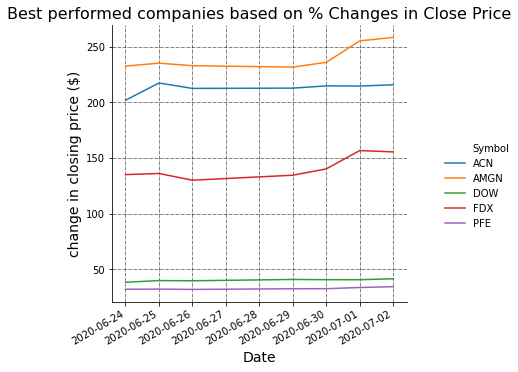

In [194]:
CreatePlotAndSavefig(tickers_bestPerformed.index, 'Best performed companies based on % Changes in Close Price', 'change in closing price ($)', 'highest growth closing price')

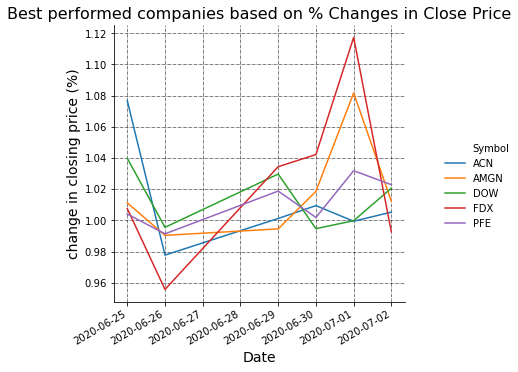

In [195]:
CreatePctPlotAndSavefig(tickers_bestPerformed.index, 'Best performed companies based on % Changes in Close Price', 'change in closing price (%)', 'highest growth closing pct change')

## Volatility

### most volatiled companies. (based on the standard deviation of percentage change)

#### Top 5 companies with highest volatillity rates among S&P 100

In [196]:
tickers_volatile = df_temp['Close'].describe().transpose().sort_values(by='std', ascending=False).head(5)#.round(2)
tickers_volatile = format_column_percentage(tickers_volatile, tickers_volatile.columns[1:])

In [197]:
tickers_volatile.index

Index(['BA', 'FDX', 'SPG', 'FB', 'GS'], dtype='object', name='Symbol')

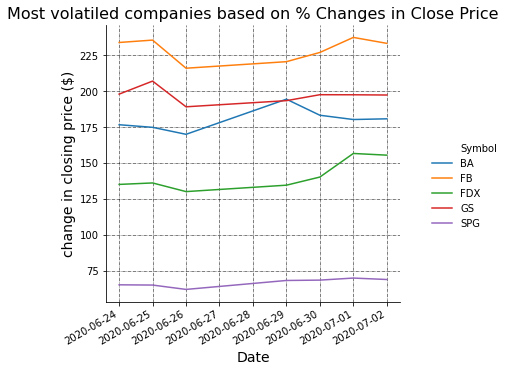

In [198]:
CreatePlotAndSavefig(tickers_volatile.index, 'Most volatiled companies based on % Changes in Close Price', 'change in closing price ($)', '2')

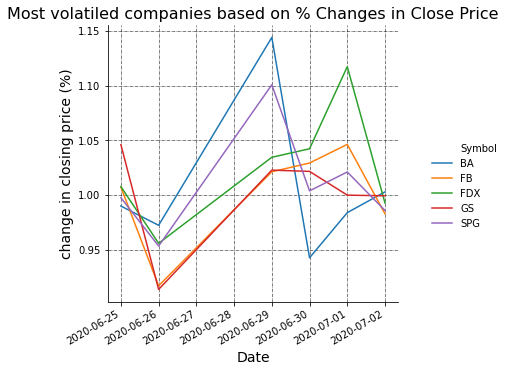

In [199]:
CreatePctPlotAndSavefig(tickers_volatile.index, 'Most volatiled companies based on % Changes in Close Price', 'change in closing price (%)', '1')

## Get date where highest drop and raise of closing price occured. 

In [200]:
highest_raise = df_Flat_pct_change.groupby(['Symbol'])['Close'].transform(max) == df_Flat_pct_change['Close']
df_Flat_pct_change[highest_raise]

,Symbol,Date,High,Low,Open,Close,Volume,Adj Close
1,ABBV,2020-06-25,0.999074,0.999682,0.986730,1.019445,0.710430,1.019445
3,ACN,2020-06-25,1.050579,1.054863,1.036446,1.076694,1.703236,1.076694
6,ALL,2020-06-25,0.999791,1.003984,0.974635,1.030984,0.602274,1.030984
10,AXP,2020-06-25,0.998474,0.986947,0.968868,1.024822,0.871960,1.024822
12,BAC,2020-06-25,1.009372,0.994510,0.965770,1.038219,0.862068,1.038219
...,...,...,...,...,...,...,...,...
474,NEE,2020-07-01,1.023531,1.003411,1.003181,1.025357,0.631992,1.025357
475,NFLX,2020-07-01,1.066960,1.015660,1.008844,1.067247,2.311754,1.067247
481,PFE,2020-07-01,1.050487,1.046230,1.061789,1.031804,2.887944,1.031804
489,SO,2020-07-01,1.017255,1.010366,1.004066,1.019672,0.763092,1.019672


In [201]:
highest_drop = df_Flat_pct_change.groupby(['Symbol'])['Close'].transform(min) == df_Flat_pct_change['Close']
drops = df_Flat_pct_change[highest_drop]

In [202]:
drops

,Symbol,Date,High,Low,Open,Close,Volume,Adj Close
35,DUK,2020-06-25,0.986354,0.987096,0.988036,0.987324,1.084034,0.987324
37,EXC,2020-06-25,0.978477,0.966611,0.988047,0.971209,1.371105,0.971209
85,SO,2020-06-25,0.984920,0.980855,0.985250,0.978427,1.098080,0.978427
101,AAPL,2020-06-26,1.000877,0.987275,1.010286,0.969274,1.492534,0.969274
102,ABBV,2020-06-26,0.999588,1.007634,1.017966,0.991133,2.272159,0.991133
...,...,...,...,...,...,...,...,...
493,TMO,2020-07-01,0.999423,1.021196,1.037950,0.992907,0.935625,0.992907
494,TXN,2020-07-01,0.993422,1.002573,1.017685,0.982909,0.721772,0.982909
501,WBA,2020-07-01,1.004462,0.975814,1.000712,0.964378,1.477008,0.964378
511,ALL,2020-07-02,0.998255,0.984272,1.003515,0.984926,1.205028,0.984926


In [203]:
drops['DateStr'] = drops['Date'].apply(lambda x: x.strftime('%Y/%m/%d'))

/Users/reejungkim/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [204]:
drops['search_key'] = drops['Symbol']  + ' ' + drops['DateStr']

/Users/reejungkim/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Search and scrap what happened to the stock on the date

In [205]:
search_list = drops.loc[drops['Symbol'].isin (tickers_bestPerformed.index)]['search_key'].tolist()

In [206]:
search_list

['ACN 2020/06/26',
 'AMGN 2020/06/26',
 'FDX 2020/06/26',
 'PFE 2020/06/26',
 'DOW 2020/06/30']

In [39]:
driver = webdriver.Chrome('/Users/reejungkim/opt/anaconda3/libexec/chromedriver')  
driver.get('https://news.google.com/topstories?hl=en-GB&tab=wn&gl=GB&ceid=GB:en')
driver.implicitly_wait(3)

In [40]:
xpath = '//*[@id="gb"]/div[2]/div[2]/div/form/div[1]/div/div/div/div/div[1]/input[2]'
search = driver.find_element_by_xpath(xpath)

In [41]:
titles = []
links = []
searched=[]

for keyword in search_list:
    driver.implicitly_wait(30)
    search.clear()
    search.send_keys(keyword)
    search.send_keys(Keys.ENTER)
    driver.implicitly_wait(30)

    url = driver.current_url
    resp = requests.get(url)
    soup = BeautifulSoup(resp.text, 'lxml')

    for link in soup.select('h3 >a')[:5]:
        href = 'https://news.google.com' + link.get('href')[1:]
        title = link.string
        searched.append(keyword)
        titles.append(title)
        links.append(href)
    
    search.clear()

In [42]:
news_data = { 'searched keyword': searched, 'title': titles, 'link': links}
news_df = pd.DataFrame(news_data, columns=['searched keyword','title', 'link'])

news_df['link'] = "<a href=" + "\"{" + news_df['link'] + "}" + "\"" + ">Click</a>"

In [43]:
news_df

,searched keyword,title,link
0,ACN 2020/06/26,"TOPIC PAGE: Coronavirus, oil price crash – imp...",https://news.google.com/articles/CBMiemh0dHBzO...
1,ACN 2020/06/26,"Company News for Jun 26, 2020",https://news.google.com/articles/CBMiRmh0dHBzO...
2,ACN 2020/06/26,Accenture (NYSE:ACN) Target Raised by Citigrou...,https://news.google.com/articles/CBMiWmh0dHBzO...
3,ACN 2020/06/26,APE Announces Commencement of New Business Act...,https://news.google.com/articles/CBMiamh0dHBzO...
4,ACN 2020/06/26,Accenture (NYSE:ACN) Target Raised by Susqueha...,https://news.google.com/articles/CBMiZWh0dHBzO...
5,AMGN 2020/06/26,Liberty Global (LBTYK) Shares Cross Below 200 DMA,https://news.google.com/articles/CAIiEMEe-DvV9...
6,AMGN 2020/06/26,IBD Live Q&A And Two Key Stock Lists For June ...,https://news.google.com/articles/CBMiQ2h0dHBzO...
7,AMGN 2020/06/26,The Top-Ranked Dividend Growth Stocks In The H...,https://news.google.com/articles/CAIiEGJJ5Bvcq...
8,AMGN 2020/06/26,Molecular Partners hopes for COVID-19 rebound ...,https://news.google.com/articles/CBMib2h0dHBzO...
9,AMGN 2020/06/26,"Active Stocks in Review: Kroger (NYSE:KR), Tar...",https://news.google.com/articles/CBMiiQFodHRwc...


In [44]:
news_df.to_csv('./news.csv')

#Open pdf file generated
subprocess.run(['open', './news.csv'], check=True)

## S&P 100 total

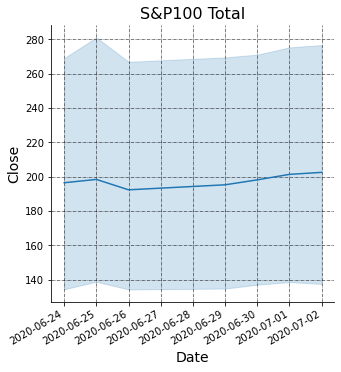

In [207]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.relplot(x='Date', y='Close', kind='line', data=df_Flat).fig.autofmt_xdate()

plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.title('S&P100 Total', fontsize=16)
plt.ylabel('Close', fontsize=14)
plt.xlabel('Date', fontsize=14)

jpg_name = 'SP100_total.jpg'
plt.savefig(jpg_name, bbox_inches='tight')

pd.options.display.float_format = '{:,.2%}'.format
display(tickers_volatile), display(tickers_bestPerformed)

In [209]:
#pd.options.display.float_format = '{:,.2f}'.format
dataToExport = df.loc[tickers_bestPerformed.index].unstack(0).describe()
dataToExport = dataToExport.transpose().reset_index().groupby(['Symbol', 'level_0']).sum().round(2)

dataToExport.rename_axis(index={"level_0":"Type"}, inplace=True)
dataToExport

count         mean          std          min          25%  \
Symbol Type                                                                   
ACN    Adj Close    7.0       212.77         5.10       201.84       212.60   
       Close        7.0       212.77         5.10       201.84       212.60   
       High         7.0       215.23         3.83       207.40       214.51   
       Low          7.0       210.59         4.74       200.50       210.61   
       Open         7.0       212.70         3.94       205.51       211.26   
       Volume       7.0   2900671.43    941043.76   2003400.00   2186300.00   
AMGN   Adj Close    7.0       240.18        11.41       231.56       232.67   
       Close        7.0       240.18        11.41       231.56       232.67   
       High         7.0       242.64        11.23       234.14       236.15   
       Low          7.0       234.41         8.19       229.98       230.89   
       Open         7.0       236.74         7.26       231.50       233.35   
       Volume       7.0   3158185.71   1648186.63   1938000.00   2026600.00   
DOW    Adj Close    7.0        40.33         1.03        38.45        39.89   
       Close        7.0        40.33         1.03        38.45        39.89   
       High         7.0        40.92         0.78        40.00        40.38   
       Low          7.0        39.42         1.19        37.68        38.52   
       Open         7.0        40.22         1.16        38.00        39.96   
       Volume       7.0   6090228.57   1857451.53   3988100.00   4429450.00   
FDX    Adj Close    7.0       140.98        10.72       130.08       134.50   
       Close        7.0       141.17        10.61       130.08       134.82   
       High         7.0       144.07        12.24       134.73       135.83   
       Low          7.0       138.82        11.58       129.28       131.17   
       Open         7.0       141.65        11.83       131.30       134.46   
       Volume       7.0   5539000.00   5678409.35   2310900.00   2346750.00   
PFE    Adj Close    7.0        32.88         0.91        32.04        32.25   
       Close        7.0        32.88         0.91        32.04        32.25   
       High         7.0        33.19         1.05        32.28        32.52   
       Low          7.0        32.52         0.96        31.61        31.91   
       Open         7.0        33.03         1.08        32.11        32.35   
       Volume       7.0  36391242.86  16645430.99  22728900.00  25080800.00   

                          50%          75%          max  
Symbol Type                                              
ACN    Adj Close       214.59       215.22       217.32  
       Close           214.59       215.22       217.32  
       High            216.90       217.41       218.45  
       Low             211.50       213.01       214.90  
       Open            213.00       215.54       216.78  
       Volume      2753700.00   3242400.00   4690200.00  
AMGN   Adj Close       235.11       245.49       258.24  
       Close           235.11       245.49       258.24  
       High            237.00       246.78       261.46  
       Low             231.80       232.20       252.87  
       Open            235.21       235.44       252.87  
       Volume      2589000.00   3475650.00   6575800.00  
DOW    Adj Close        40.75        40.87        41.59  
       Close            40.75        40.87        41.59  
       High             40.95        41.25        42.25  
       Low              39.76        40.26        40.91  
       Open             40.59        40.67        41.66  
       Volume      5986900.00   7731950.00   8333800.00  
FDX    Adj Close       135.46       147.85       156.66  
       Close           136.11       147.85       156.66  
       High            138.00       150.24       163.65  
       Low             134.13       145.10       155.76  
       Open            136.22       148.12       158.85  
       Volume      3282000.00   5259550

In [210]:
#format_column_percentage(dataToExport, dataToExport.columns[1:])

dataToExport2 = df.loc[tickers_bestPerformed.index].unstack(0).describe().stack(0)
dataToExport2

# Create PDF file

In [211]:
today = dt.datetime.today().strftime('%Y-%m-%d')
pdf_file_name = "Report "+ today +".pdf"

In [49]:
def PrepareTableForReportLab(dataframe):
    
    data = dataframe

    'handling grouped first index column'
    a= []
    for i in range(len(data)):
        #print(i, data.index.get_level_values(0)[i])
        if data.index.get_level_values(0)[i-1] == data.index.get_level_values(0)[i]:
            a.append(i)
    a.sort(reverse=True)

    as_list = data.index.get_level_values(0).tolist()
    for i in a:
        as_list[i] = ""

        
    'flat dataframe'
    data = data.reset_index()
    'remove duplicated values from first column which was index before resetting index'
    first_col_name = data.columns[0]
    data[first_col_name] = as_list 
    
    #data = dataframe.reset_index()
    #colwidths = 800/len(data.columns) 
    data = [data.columns.to_list()] + data.values.tolist() 

    #tbl = Table(data) # 
    tbl = Table(data) #, colwidths ) #, rowheights)
    tbl.setStyle(TableStyle([
    ('INNERGRID', (0, 0), (-1, -1), 0.25, colors.black),
    ('BOX', (0, 0), (-1, -1), 0.25, colors.black),
    ('ALIGN', (1,1), (-1,-1), 'RIGHT'),
    ('BACKGROUND', (0,0), (-1,0), colors.Color(0,0.7,0.7))
    ]))
    
    return tbl

def PrepareTableForReportLab_News_df(dataframe):
    
    data = dataframe

    'handling grouped first index column'
    a= []
    for i in range(len(data)):
        #print(i, data.index.get_level_values(0)[i])
        if data.index.get_level_values(0)[i-1] == data.index.get_level_values(0)[i]:
            a.append(i)
    a.sort(reverse=True)

    as_list = data.index.get_level_values(0).tolist()
    for i in a:
        as_list[i] = ""

        
    'flat dataframe'
    data = data.reset_index()
    'remove duplicated values from first column which was index before resetting index'
    first_col_name = data.columns[0]
    data[first_col_name] = as_list 
    
    #data = dataframe.reset_index()
    colwidths = 800/len(data.columns) 
    rowheights = 1.5*inch
    data = [data.columns.to_list()] + data.values.tolist() 

    #tbl = Table(data) # 
    tbl = Table(data , colwidths, rowheights)
    tbl.setStyle(TableStyle([
    ('INNERGRID', (0, 0), (-1, -1), 0.25, colors.black),
    ('BOX', (0, 0), (-1, -1), 0.25, colors.black),
    ('ALIGN', (1,1), (-1,-1), 'RIGHT'),
    ('BACKGROUND', (0,0), (-1,0), colors.Color(0,0.7,0.7))
    ]))
    
    return tbl

In [50]:
story = []

In [51]:
story.append(Paragraph("Highest growth rates", getSampleStyleSheet()['Heading1']))
story.append(Paragraph("highest growth rates in past <i>" + str(days_to_lookback) + " days</i>.",  getSampleStyleSheet()['Normal']))
story.append(Spacer(1,20))
story.append((PrepareTableForReportLab(dataToExport)))
story.append(Spacer(1,20))
story.append(PrepareTableForReportLab(tickers_bestPerformed))
story.append(PageBreak())

story.append(Paragraph("Volatility", getSampleStyleSheet()['Heading1']))
story.append(Paragraph("highest volatility rates in past <i>" + str(days_to_lookback)  + " days</i>.",  getSampleStyleSheet()['Normal']))
story.append(Spacer(1,20))
story.append(PrepareTableForReportLab(tickers_volatile))
story.append(PageBreak())

#### Add graph images saved in the timestamped folder

In [52]:
for file in sorted(os.listdir(reportDir), key=os.path.getmtime):
    if file.endswith('jpg'):
        temp = file
        temp = 'image_'+ temp
        print(temp)
        temp = Image(file)
        #story.append(Spacer(1, 20))
        story.append(temp)

image_highest growth closing price.jpg
image_highest growth closing pct change.jpg
image_2.jpg
image_1.jpg
image_SP100_total.jpg


story.append(PageBreak())
story.append(PrepareTableForReportLab_News_df(news_df))

In [53]:
doc = SimpleDocTemplate(pdf_file_name, pagesize = landscape(letter), topMargin = inch * .25, bottomMargin = inch * .25)
doc.build(story)

In [54]:
#open folder
subprocess.run(['open', reportDir], check=True)

CompletedProcess(args=['open', '/Users/reejungkim/Documents/Git/reporting automation/Output2020-07-03 23-31-21'], returncode=0)

In [55]:
#Open pdf file generated
subprocess.run(['open', pdf_file_name], check=True)

CompletedProcess(args=['open', 'Report 2020-07-03.pdf'], returncode=0)